__Author:__ Bram Van de Sande

__Date:__ 20 APR 2018

__Outline:__ To make the pySCENIC code more robust to the selection of the network inference method in the first step of
the pipeline, the default values for weight thresholds should not be absolute (i.e. 0.001 or 0.005) but percentile based.

As example we're using the example run used in the tutorial of the R version of SCENIC.

In [1]:
DATA_FOLDER='/Users/bramvandesande/Projects/lcb/resources'

In [2]:
!ls {DATA_FOLDER}

1.1_exprMatrix_filtered.RData     grnboost2_adjacencies.tsv
1.1_exprMatrix_filtered.csv       hs_tfs.txt
1.2_inputTFs.RData                input_tfs.txt
1.2_inputTFs.csv                  mm_tfs.txt
1.5_GENIE3_linkList.RData         motifs-v9-nr.hgnc-m0.001-o0.0.tbl
1.5_GENIE3_linkList.csv           motifs-v9-nr.mgi-m0.001-o0.0.tbl
GSE60361.mtx.csv                  sc-cancer-compendium
GSE60361_C1-3005-Expression.txt   sc-map-datasets
exp_mtx.csv                       zeisel_et_al


### Preliminary work: convert RData 

In [3]:
import pandas as pd
import os

In [ ]:
df_tfs = pd.read_csv(os.path.join(DATA_FOLDER, '1.2_inputTFs.csv'))
with open(os.path.join(DATA_FOLDER, 'input_tfs.txt'), 'wt') as f:
    f.write("\n".join(df_tfs.x.values) + "\n")

In [ ]:
pd.read_csv(os.path.join(DATA_FOLDER, '1.1_exprMatrix_filtered.csv'), index_col=0).T.to_csv(os.path.join(DATA_FOLDER, 'exp_mtx.csv'))

### Preliminary work: create adjacency list according to GRNBoost2 algorithm

In [ ]:
from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2
import pandas as pd
import os
from dask.distributed import LocalCluster, Client

DATA_FOLDER='.'

if __name__ == '__main__':
    ex_matrix = pd.read_csv(os.path.join(DATA_FOLDER, 'exp_mtx.csv'), index_col=0)
    tf_names = load_tf_names(os.path.join(DATA_FOLDER, 'input_tfs.txt'))

    local_cluster = LocalCluster(n_workers=48, threads_per_worker=1)
    client = Client(local_cluster)

    adjacencies = grnboost2(expression_data=ex_matrix, tf_names=tf_names, verbose=True, client_or_address=client)
    adjacencies.to_csv(os.path.join(DATA_FOLDER, 'grnboost2_adjacencies.tsv'), index=False, sep='\t')

    client.close()
    local_cluster.close()

### Compare adjacency lists

In [4]:
adjacencies_genie3 = pd.read_csv(os.path.join(DATA_FOLDER, '1.5_GENIE3_linkList.csv'), usecols=[1, 2, 3]).sort_values(by='weight', ascending=False)
adjacencies_genie3.rename(columns={'Target': 'target', 'weight': 'importance'}, inplace=True)

In [5]:
adjacencies_genie3.head()

,TF,target,importance
0,Dab2,Pf4,0.173916
1,Dab2,Mrc1,0.167264
2,Dab2,Cbr2,0.146576
3,Dab2,Tyrobp,0.144853
4,Dab2,Stab1,0.142367


In [6]:
adjacencies_grnboost2 = pd.read_csv(os.path.join(DATA_FOLDER, 'grnboost2_adjacencies.tsv'), sep='\t').sort_values(by='importance', ascending=False)

In [7]:
adjacencies_grnboost2.head()

,TF,target,importance
0,Rpl35,Rpl18a,99.115851
1,Dab2,Mrc1,97.608051
2,Rpl35,Rps28,95.306114
3,Rpl35,Rpl32,94.416149
4,Mylk,Myl9,93.607445


In [8]:
import matplotlib.pyplot as plt

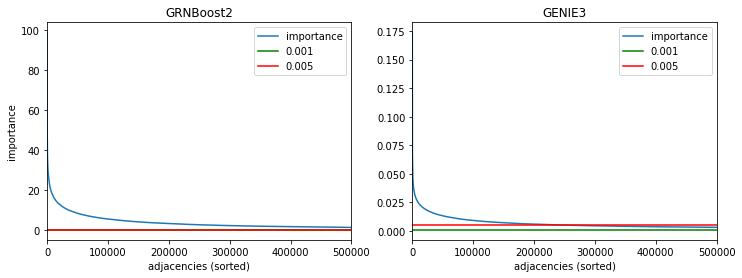

In [9]:
y_lim = 500000
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
df = adjacencies_grnboost2
ax1.plot(df.index.values, df.importance, '-')
ax1.set_xlim([0,y_lim])
ax1.set_title('GRNBoost2')
ax1.set_ylabel('importance')
ax1.set_xlabel('adjacencies (sorted)')
ax1.plot([0, y_lim], [0.001, 0.001], 'g-', label='0.001')
ax1.plot([0, y_lim], [0.005, 0.005], 'r-', label='0.005')
ax1.legend()
df = adjacencies_genie3
ax2.plot(df.index.values, df.importance, '-')
ax2.set_xlim([0,y_lim])
ax2.set_title('GENIE3')
ax2.plot([0, y_lim], [0.001, 0.001], 'g-', label='0.001')
ax2.plot([0, y_lim], [0.005, 0.005], 'r-', label='0.005')
ax2.set_xlabel('adjacencies (sorted)')
ax2.legend()

In [10]:
percentiles = [0.05, 0.10, 0.25, 0.50, 0.75, 0.90]
adjacencies_genie3.importance.quantile(percentiles)

0.05    0.001037
0.10    0.001077
0.25    0.001216
0.50    0.001567
0.75    0.002385
0.90    0.004364
Name: importance, dtype: float64

In [11]:
percentiles = [0.05, 0.10, 0.25, 0.50, 0.75, 0.90]
adjacencies_grnboost2.importance.quantile(percentiles)

0.05    0.010404
0.10    0.031795
0.25    0.089075
0.50    0.182801
0.75    0.456872
0.90    1.353637
Name: importance, dtype: float64

/Users/bramvandesande/miniconda3/envs/pyscenic_dev/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


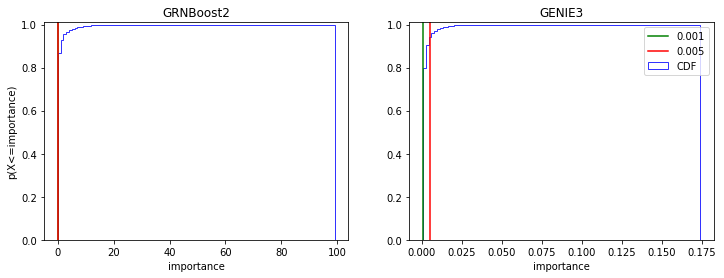

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
df = adjacencies_grnboost2
ax1.hist(df.importance, normed=True, cumulative=True, histtype='step',label='GRNBoost2', alpha=0.8, color='b', bins=100)
ax1.set_title('GRNBoost2')
ax1.set_ylim([0, 1.01])
ax1.plot([0.001] * 2, [0, 1.01], 'g')
ax1.plot([0.005] * 2, [0, 1.01], 'r')
ax1.set_ylabel('p(X<=importance)')
ax1.set_xlabel('importance')
df = adjacencies_genie3
ax2.hist(df.importance, normed=True, cumulative=True, histtype='step',label='CDF', alpha=0.8, color='b', bins=100)
ax2.set_title('GENIE3')
ax2.set_ylim([0, 1.01])
ax2.plot([0.001] * 2, [0, 1.01], 'g', label='0.001')
ax2.plot([0.005] * 2, [0, 1.01], 'r', label='0.005')
ax2.set_ylabel('')
ax2.set_xlabel('importance')
ax2.legend()
pass

In [13]:
from scipy import stats

[stats.percentileofscore(adjacencies_genie3.importance, thr) for thr in [0.001, 0.005]]

[0.0, 91.82930632121473]

In [14]:
from pyscenic.utils import modules4thr, modules4top_factors, modules4top_targets
from itertools import chain, repeat
from collections import defaultdict
from operator import attrgetter
import seaborn as sns
import numpy as np

In [15]:
def derive_modules(adjacencies):
    thresholds = [0.001, 0.005]
    percentiles = [0.05, 0.10, 0.25, 0.50, 0.75, 0.90]
    top_n_targets = [50,]
    top_n_regulators = [5,10,50]
    return chain(
        chain.from_iterable(map(lambda thr: modules4thr(adjacencies, thr), thresholds)),
        chain.from_iterable(map(lambda t: modules4thr(adjacencies, t[0], pattern="weight>{}%".format(t[1]*100)),
                                zip(list(adjacencies.importance.quantile(percentiles)), percentiles))),
        chain.from_iterable(map(lambda n: modules4top_targets(adjacencies, n), top_n_targets)),
        chain.from_iterable(map(lambda n: modules4top_factors(adjacencies, n), top_n_regulators)))

In [16]:
modules_genie3 = list(derive_modules(adjacencies_genie3))
modules_grnboost2 = list(derive_modules(adjacencies_grnboost2))

In [17]:
len(modules_genie3)

12022

In [18]:
len(modules_grnboost2)

12035

In [19]:
def todict(modules):
    def singleton(context):
        return next(iter(context))

    name2modules = defaultdict(list)
    for module in modules:
        name2modules[singleton(module.context)].append(module)
    return name2modules

In [20]:
def stats(modules, name):
    def gettype(module):
        # (+) Is also used for indicating no correlation assessed between TF and its target gene.
        return "(-)" if "repressing" in module.context else "(+)"

    return pd.DataFrame(
            data=list(
                zip(map(len, modules), 
                    repeat(name), 
                    map(attrgetter('transcription_factor'), modules),
                    map(gettype, modules)), 
                ), 
            columns=['size', 'method', 'tf', 'type'])

/Users/bramvandesande/miniconda3/envs/pyscenic_dev/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1859: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
/Users/bramvandesande/miniconda3/envs/pyscenic_dev/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1860: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
/Users/bramvandesande/miniconda3/envs/pyscenic_dev/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1872: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/Users/bramvandesande/miniconda3/envs/pyscenic_dev/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1879: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)


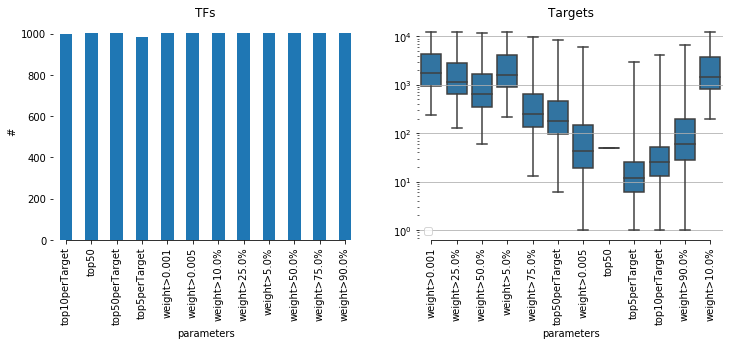

In [21]:
name2modules = todict(modules_genie3)
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(12,4))
df = pd.concat([stats(modules, name) for name, modules in name2modules.items()])
ax2.set_ylabel('#')
ax2.set_title('TFs')
df[['method', 'type', 'tf']].drop_duplicates().groupby(['method', 'type'])['method'].count().unstack('type').plot(kind='bar', stacked=True, ax=ax2, legend=False)
ax2.set_xlabel('parameters')

ax3.set_yscale("log")
sns.boxplot(y="size", x="method", hue='type', data=df.sort_index(), whis=np.inf, ax=ax3)
ax3.yaxis.grid(True)
ax3.set(ylabel="", title='Targets')
sns.despine(trim=True, left=True)
plt.xticks(rotation=90)
ax3.set_xlabel('parameters')
ax3.legend([])

/Users/bramvandesande/miniconda3/envs/pyscenic_dev/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1859: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
/Users/bramvandesande/miniconda3/envs/pyscenic_dev/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1860: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
/Users/bramvandesande/miniconda3/envs/pyscenic_dev/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1872: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/Users/bramvandesande/miniconda3/envs/pyscenic_dev/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1879: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)


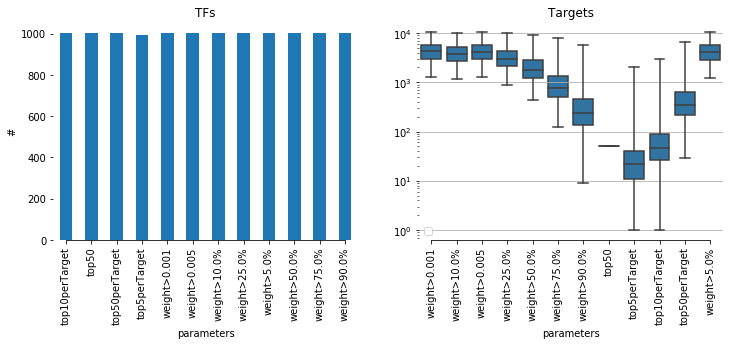

In [22]:
name2modules = todict(modules_grnboost2)
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(12,4))
df = pd.concat([stats(modules, name) for name, modules in name2modules.items()])
ax2.set_ylabel('#')
ax2.set_title('TFs')
df[['method', 'type', 'tf']].drop_duplicates().groupby(['method', 'type'])['method'].count().unstack('type').plot(kind='bar', stacked=True, ax=ax2, legend=False)
ax2.set_xlabel('parameters')

ax3.set_yscale("log")
sns.boxplot(y="size", x="method", hue='type', data=df.sort_index(), whis=np.inf, ax=ax3)
ax3.yaxis.grid(True)
ax3.set(ylabel="", title='Targets')
sns.despine(trim=True, left=True)
plt.xticks(rotation=90)
ax3.set_xlabel('parameters')
ax3.legend([])

In [23]:
ex_matrix = pd.read_csv(os.path.join(DATA_FOLDER, 'exp_mtx.csv'), index_col=0)

In [24]:
from pyscenic.utils import modules_from_adjacencies

modules = list(modules_from_adjacencies(adjacencies_grnboost2, ex_matrix, "MGI"))

In [25]:
len(modules)

8791

In [41]:
from cytoolz import pipe
from cytoolz.curried import map, mapcat
set(pipe(modules, map(attrgetter('context')), mapcat(list)))

{'activating',
 'repressing',
 'top10perTarget',
 'top50',
 'top50perTarget',
 'top5perTarget',
 'weight>10.0%',
 'weight>5.0%'}